https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [1]:
from Database import db_mongo

from Utilities import clean_text

import string

db = db_mongo.db_mongo()

df = db.get_text_full_resume(100000000)

df = df.sample(frac=1).reset_index(drop=True)

df['text'] = df['text'].str.replace('\n',' ').replace('\x0c',' ')
 
df['text'] = [word for word in df['text'] if word not in string.punctuation]



Init DB


## Limpiar Texto

In [2]:
ct = clean_text.CleanText()

df['text'] = ct.cleanner_process(df["text"])

[nltk_data] Downloading package wordnet to /home/kguttas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     2484 non-null   object
 1   text    2484 non-null   object
 2   class   2484 non-null   object
dtypes: object(3)
memory usage: 58.3+ KB


In [4]:
df.describe()

,_id,text,class
count,2484,2484,2484
unique,2484,2482,24
top,e9dedf03-c803-4a72-9158-1bbb3e3c3c31,financ offic profession summari attain fulltim...,INFORMATION-TECHNOLOGY
freq,1,2,120


In [5]:
df.head()

,_id,text,class
0,db17a3c5-0c36-4be6-9c23-3a0612f2f73f,physic therapist technician educ glenco high s...,CONSTRUCTION
1,3f05bcb0-d3bb-42e1-9e68-cd8dff854a63,busi develop repres accomplish achiev driven r...,BUSINESS-DEVELOPMENT
2,af2ca4a7-98f4-44b4-920f-dcdef52820b4,program analyst profession summari member stak...,AGRICULTURE
3,c7162999-4a07-4e22-a756-d685eb84a23f,sale associ summari courteou depend sale accoc...,SALES
4,55fb9b7c-3498-4435-8a83-280280c066dd,administr assist summari determin proactiv adm...,PUBLIC-RELATIONS


In [6]:
from io import StringIO
import pandas as pd

col = ['text', 'class']
df_new = df[col]
df_new = df_new[pd.notnull(df_new['text'])]
df_new.head()

,text,class
0,physic therapist technician educ glenco high s...,CONSTRUCTION
1,busi develop repres accomplish achiev driven r...,BUSINESS-DEVELOPMENT
2,program analyst profession summari member stak...,AGRICULTURE
3,sale associ summari courteou depend sale accoc...,SALES
4,administr assist summari determin proactiv adm...,PUBLIC-RELATIONS


In [7]:
df_new.columns = ['text', 'class' ]
df_new['category_id'] = df_new['class'].factorize()[0]

category_id_df = df_new[['class', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'class']].values)

df_new.head()

,text,class,category_id
0,physic therapist technician educ glenco high s...,CONSTRUCTION,0
1,busi develop repres accomplish achiev driven r...,BUSINESS-DEVELOPMENT,1
2,program analyst profession summari member stak...,AGRICULTURE,2
3,sale associ summari courteou depend sale accoc...,SALES,3
4,administr assist summari determin proactiv adm...,PUBLIC-RELATIONS,4


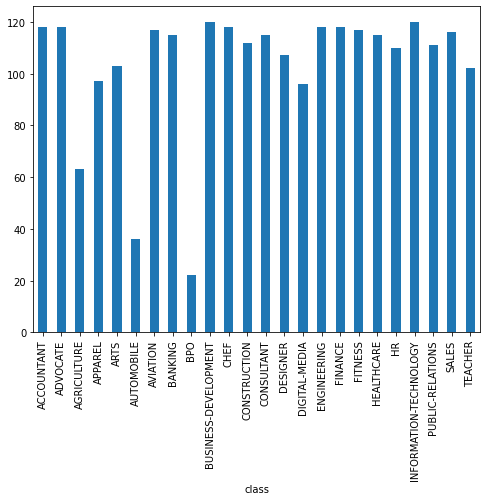

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_new.groupby('class').text.count().plot.bar(ylim=0)
plt.show()

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.00001, norm='l2', 
                        encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df_new.text).toarray()
labels = df_new.category_id
features.shape

(2484, 525810)

In [10]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'ACCOUNTANT':
  . Most correlated unigrams:
. reconcili
. ledger
  . Most correlated bigrams:
. gener ledger
. account summari
# 'ADVOCATE':
  . Most correlated unigrams:
. advocaci
. advoc
  . Most correlated bigrams:
. advoc compani
. advoc summari
# 'AGRICULTURE':
  . Most correlated unigrams:
. farmer
. agricultur
  . Most correlated bigrams:
. agricultur educ
. natur resourc
# 'APPAREL':
  . Most correlated unigrams:
. merchandis
. apparel
  . Most correlated bigrams:
. assist buyer
. apparel product
# 'ARTS':
  . Most correlated unigrams:
. art
. martial
  . Most correlated bigrams:
. languag art
. art teacher
# 'AUTOMOBILE':
  . Most correlated unigrams:
. subrog
. automobil
  . Most correlated bigrams:
. liabil claim
. automobil servic
# 'AVIATION':
  . Most correlated unigrams:
. aircraft
. aviat
  . Most correlated bigrams:
. aviat mainten
. state aviat
# 'BANKING':
  . Most correlated unigrams:
. loan
. bank
  . Most correlated bigrams:
. bank center
. busi bank
# 'BPO':
 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_new['text'], df_new['class'], random_state = 0, shuffle= True)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [12]:
X_test.iloc[25]

'camryn hilliard profession summari highli motiv sale associ with extens custom servic sale experi outgo sale profession with track record drive increas sale improv buy experi elev compani profil with target market consist recogn sale perform excel custom servic skill current trend knowledg stock replenish merchandis knowledg sale except custom servic social percept problemsolv skill client servic clothingaccessori minor vetranari pandora jewleri product knowledg excel peopl skill sale expertis sale train cash handl multitask strength cash regist oper educ univers scranton citi state expect bachelor scienc psycholog polit scienc work histori compani name sale associ citi state current engag with custom effect build rapport last relationship deliv high level assist locat product check store system merchandis other site educ custom promot enhanc sale complet order through store provid system system organ product deliveri meet custom timet appli secur loss prevent train toward recogn risk

In [13]:
print(clf.predict(count_vect.transform([X_test.iloc[25]])))

['SALES']


In [14]:
df_new[df_new['text'].str.contains(X_test.iloc[25])]

,text,class,category_id
1725,camryn hilliard profession summari highli moti...,SALES,3


In [15]:
print(clf.predict(count_vect.transform([X_test.iloc[38]])))

['HR']


In [16]:
df_new[df_new['text'] == X_test.iloc[38]]

,text,class,category_id
1328,clerk summari translat busi vision into initi...,HR,8


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

KeyboardInterrupt: 

In [18]:
cv_df.groupby('model_name').accuracy.mean()

KeyError: 'model_name'

In [31]:
category_id_df

,class,category_id
0,CONSTRUCTION,0
1,BUSINESS-DEVELOPMENT,1
2,AGRICULTURE,2
3,SALES,3
4,PUBLIC-RELATIONS,4
5,ENGINEERING,5
6,ARTS,6
7,TEACHER,7
8,HR,8
10,INFORMATION-TECHNOLOGY,9


NameError: name 'sns' is not defined

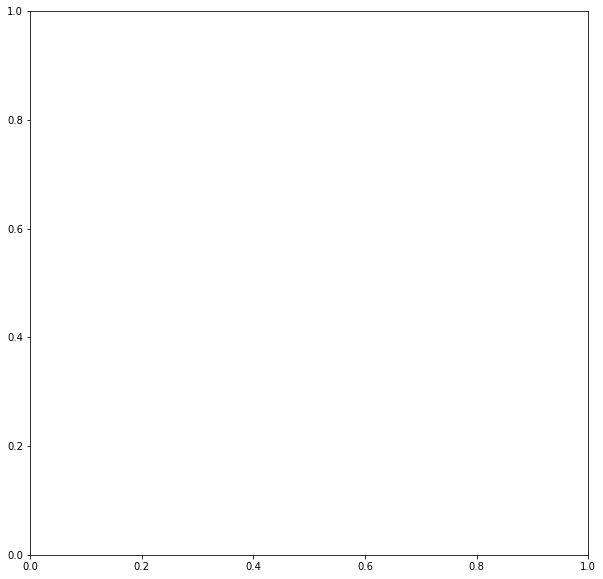

In [20]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_new.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df["class"].values, yticklabels=category_id_df["class"].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
from IPython.display import display

for predicted in category_id_df.category_id:
    
    for actual in category_id_df.category_id:
       
        if predicted != actual and conf_mat[actual, predicted] >= 5:
            
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['class', 'text']])
            print('')

'ENGINEERING' predicted as 'CONSTRUCTION' : 5 examples.


,class,text
2397,ENGINEERING,engin technician summari obtain posit field ci...
2441,ENGINEERING,engin intern summari contribut skill experi fu...
2027,ENGINEERING,engin intern profession summari petroleum engi...
1716,ENGINEERING,engin project manag summari seek long term emp...
1700,ENGINEERING,engin technician profession summari engin tech...



'SALES' predicted as 'BUSINESS-DEVELOPMENT' : 6 examples.


,class,text
2442,SALES,sale director summari continu career with orga...
2096,SALES,sale manag territori sale manag experi sale ma...
1763,SALES,sale summari sale execut offer outstand sale p...
1476,SALES,merchandis sale summari titl equip with excel ...
1295,SALES,sale manag summari driven sale market professi...
202,SALES,sale associ summari sale busi develop busi dev...



'ARTS' predicted as 'SALES' : 5 examples.


,class,text
704,ARTS,line attend summari resultsori supervisor with...
303,ARTS,certifi custom framer qualif abil multitask ce...
1506,ARTS,sale consult summari driven develop implement ...
983,ARTS,custom servic associatecashi summari highli mo...
6,ARTS,sale consult summari driven develop implement ...



'ADVOCATE' predicted as 'SALES' : 5 examples.


,class,text
457,ADVOCATE,custom advoc profession summari rotc year high...
768,ADVOCATE,gradat candid advoc execut summari highenergi ...
1217,ADVOCATE,custom care advoc experi custom care advoc cur...
30,ADVOCATE,custom advoc profession summari custom care pr...
521,ADVOCATE,child perform welfar advoc summari administr p...



'APPAREL' predicted as 'SALES' : 5 examples.


,class,text
1010,APPAREL,shoe dept lead supervisor accomplish kellermey...
517,APPAREL,gener manag summari compani that would offer g...
574,APPAREL,creativ director profession summari hard work ...
1280,APPAREL,holder summari highli organ effici multitask ...
1081,APPAREL,groceri clerk experi groceri clerk compani nam...



'ARTS' predicted as 'TEACHER' : 8 examples.


,class,text
2372,ARTS,nation sale manag summari desir advanc profess...
850,ARTS,tutor consult execut profil motiv enthusiast e...
2463,ARTS,english languag art teacher summari experienc ...
1160,ARTS,activ specialist summari highli knowledg creat...
2083,ARTS,colleg assist summari profession leader with s...
2030,ARTS,princip profession summari commit passion edu...
2363,ARTS,danc educ profession summari person proactiv c...
141,ARTS,high school english languag art teacher profe...



'CONSULTANT' predicted as 'INFORMATION-TECHNOLOGY' : 10 examples.


,class,text
1098,CONSULTANT,consult profession summari talent profession ...
2148,CONSULTANT,consult summari over seven year softwar appli...
302,CONSULTANT,pavithra shetti summari customerori princip co...
2348,CONSULTANT,consult summari colleg graduat with interest i...
895,CONSULTANT,consult summari technician secur analyst secur...
758,CONSULTANT,consult career overview director inform techn...
963,CONSULTANT,consult profil knowledg most common oper syste...
1719,CONSULTANT,consult profession profil highli motiv selfdri...
794,CONSULTANT,consult profession summari selfmotiv detail o...
2378,CONSULTANT,consult skill ass project manag consult with c...



'FINANCE' predicted as 'ACCOUNTANT' : 6 examples.


,class,text
53,FINANCE,financ project coordin summari accommod projec...
1188,FINANCE,financ assist summari accur alert ambiti analy...
1013,FINANCE,senior execut financ profil part esteem organ ...
917,FINANCE,financ summari account profession with extens...
458,FINANCE,financ director summari financ director with e...
2342,FINANCE,financ specialist summari work profession envi...



'ADVOCATE' predicted as 'HEALTHCARE' : 6 examples.


,class,text
618,ADVOCATE,lead pharmaci technician advoc supervisor expe...
48,ADVOCATE,servic advoc clinic support summari over year ...
1732,ADVOCATE,administr assist profession summari profession...
2398,ADVOCATE,revenu cycl advoc summari dedic focus offic ma...
2289,ADVOCATE,patient advoc career overview skill medic assi...
2434,ADVOCATE,patient advoc summari custom servic profession...



'CONSULTANT' predicted as 'HEALTHCARE' : 6 examples.


,class,text
651,CONSULTANT,consult profession overview master social work...
2406,CONSULTANT,consult summari versatil manag profession trai...
1953,CONSULTANT,consult profession summari certifi nurs assist...
117,CONSULTANT,consult summari transit militari profession ea...
491,CONSULTANT,consult execut profil profession health care o...
781,CONSULTANT,consult experi consult compani name citi state...


In [22]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


# 'ACCOUNTANT':
  . Top unigrams:
       . reconcil
       . account
  . Top bigrams:
       . account summari
       . account compani
# 'ADVOCATE':
  . Top unigrams:
       . advoc
       . court
  . Top bigrams:
       . advoc summari
       . advoc compani
# 'AGRICULTURE':
  . Top unigrams:
       . agricultur
       . farmer
  . Top bigrams:
       . natur resourc
       . research assist
# 'APPAREL':
  . Top unigrams:
       . apparel
       . merchandis
  . Top bigrams:
       . store manag
       . product develop
# 'ARTS':
  . Top unigrams:
       . art
       . martial
  . Top bigrams:
       . art teacher
       . languag art
# 'AUTOMOBILE':
  . Top unigrams:
       . automobil
       . auto
  . Top bigrams:
       . automobil servic
       . liabil claim
# 'AVIATION':
  . Top unigrams:
       . aviat
       . aircraft
  . Top bigrams:
       . aviat suppli
       . state aviat
# 'BANKING':
  . Top unigrams:
       . bank
       . loan
  . Top bigrams:
       . busi bank
   

In [24]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['class'].unique()))

                        precision    recall  f1-score   support

          CONSTRUCTION       0.67      0.91      0.78        34
  BUSINESS-DEVELOPMENT       0.55      0.81      0.65        37
           AGRICULTURE       0.60      0.29      0.39        21
                 SALES       0.43      0.59      0.49        41
      PUBLIC-RELATIONS       0.68      0.84      0.75        31
           ENGINEERING       0.60      0.74      0.66        46
                  ARTS       0.36      0.12      0.18        33
               TEACHER       0.58      0.85      0.69        34
                    HR       0.71      0.94      0.81        49
INFORMATION-TECHNOLOGY       0.55      0.89      0.68        37
               BANKING       0.60      0.55      0.57        33
              AVIATION       0.78      0.81      0.79        36
               FINANCE       0.76      0.72      0.74        39
            ACCOUNTANT       0.69      0.93      0.79        41
         DIGITAL-MEDIA       0.67      

### Prueba con un CV

In [54]:
from tika import parser # pip install tika

path_file = "data/resumes/estandar/HEALTHCARE/KIRAN KUMAR.pdf"

raw = parser.from_file(path_file)

print(str(raw['content']).strip())

KIRAN KUMAR 
Email: kumarjava174@gmail.com                                                                                                                                             

Mobile:510-770-6277 
Professional Summary 

• 8+ years of IT experience in design (OOA, OOD), development, testing and documentation of Enterprise applications 
using J2EE technologies. Worked extensively in J2EE (JSP, Servlets, EJB), Struts, JSF, Spring, Hibernate, IBM Web sphere 
Application Server, BEA web logic Server 7.x, JDBC, JNDI, XML and RDBMS like Oracle. Strong knowledge in Software 
Development Life Cycle (SDLC), worked in most of the life cycle phases.  

• Good knowledge and working experience in Object Oriented Analysis (OOA) and Object Oriented Design (OOD)  
• Working knowledge in multi-tiered distributed environment, OOP concepts, good understanding of Software 

Development Lifecycle (SDLC)  
•  Experience in web application design using open source Spring, JSF & Struts Frameworks and 

In [55]:
clean_cv = ct.cleanner_process([str(raw['content']).strip()])

In [56]:
clean_cv

['kiran kumar email kumarjavagmailcom mobil profession summari year experi design develop test document enterpris applic use technolog work extens servlet strut spring hibern sphere applic server logic server jdbc jndi rdbm like oracl strong knowledg softwar develop life cycl sdlc work most life cycl phase good knowledg work experi object orient analysi object orient design work knowledg multiti distribut environ concept good understand softwar develop lifecycl sdlc experi applic design use open sourc spring strut framework java design pattern experi client side technolog such html jqueri javascript expertis spring modul such spring core depend inject transact expertis develop use javascript ajax html expertis technolog xpath xslt extens experi implement framework use spring strut jeearchitectur experi work variou spring modul spring along with hibern backend tool implement persist layer map pojo strong work experi applic develop use core java spring hibern servic servlet html tomcat e

In [57]:
features = tfidf.transform(clean_cv).toarray()
labels = df_new.category_id
features.shape

(1, 525810)

In [58]:
y_pred_cv= model.predict(features)

In [59]:
y_pred_cv[0]

19

In [60]:
category_id_df[category_id_df['category_id']==y_pred_cv[0]]

,class,category_id
54,CONSULTANT,19
